# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it


Computer vision-based object detection techniques can be applied in super market settings to build a system that can identify products on store shelves.
An example of how this system could be used would be to assist visually impaired customers or automate common store management tasks like detecting low-stock or misplaced products, given an image of a shelf in a store.

## Task
Develop a computer vision system that, given a reference image for each product, is able to identify such product from one picture of a store shelf.

<figure>
<a href="https://imgbb.com/">
  <center>
  <img src="https://i.ibb.co/TwkMWnH/Screenshot-2024-04-04-at-14-54-51.png" alt="Screenshot-2024-04-04-at-14-54-51" border="0" width="300" />
</a>
</figure>

For each type of product displayed in the
shelf the system should report:
1. Number of instances;
1. Dimension of each instance (width and height in pixel of the bounding box that enclose them);
1. Position in the image reference system of each instance (center of the bounding box that enclose them).

#### Example of expected output
```
Product 0 - 2 instance found:
  Instance 1 {position: (256, 328), width: 57px, height: 80px}
  Instance 2 {position: (311, 328), width: 57px, height: 80px}
Product 1 – 1 instance found:
.
.
.
```

### Track A - Single Instance Detection
Develop an object detection system to identify single instance of products given one reference image for each item and a scene image.

The system should be able to correctly identify all the product in the shelves
image.

### Track B - Multiple Instances Detection
In addition to what achieved at step A, the system should also be able to detect multiple instances of the same product.

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify.
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios. The images contained in this folder are corrupted by noise.

#### Track A - Single Instance Detection
* **Models**: {ref1.png to ref14.png}.
* **Scenes**: {scene1.png to scene5.png}.

#### Track B - Multiple Instances Detection
* **Models**: {ref15.png to ref27.png}.
* **Scenes**: {scene6.png to scene12.png}.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# !cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
# !unzip dataset.zip

## Evaluation criteria
1. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

2. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed approach.

## PREPROCESSING

In [54]:
import numpy as np
import cv2
from skimage.filters import unsharp_mask
from matplotlib import pyplot as plt
import re
import os

The following function shows the denoising processes, and the various attempts that have been made to understand which of the various methods produced the best output. In this case, the returned value is dst_median7, which is the denoising that first applies a median filter with ksize = 7, and afterwarts the Non-Linear Means filter. 

In [3]:
def show_denoising(img, k_size, sigma, show):

    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #median filter, then mean and finally bilateral
    median = cv2.medianBlur(img, 5)
    means_and_median = cv2.fastNlMeansDenoisingColored(median,None,10,10,7,21)
    means_and_median_and_bilateral = cv2.bilateralFilter(means_and_median, 5, 150, 75)

    #median filter with parameter 7, followed by bilateral
    median_7 = cv2.medianBlur(img, 7)
    bilateral_median7 = cv2.bilateralFilter(median_7, 9, 255, 255)

    #median filter with parameter 7, followed by Non Linear Means
    dst_median7 = cv2.fastNlMeansDenoisingColored(median_7,None,10,10,7,21)

    #cv2.bilateralFilter(img, filter_size, sigmaColor, sigmaSpace)
    bilateral = cv2.bilateralFilter(img, 5, 200, 75)

    #Now I want to try means and bilateral, as suggested
    means = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
    bilateral_means = cv2.bilateralFilter(means, 9, 150, 75)

    
    
    sharpening_kernel = np.array([[0, -1, 0],
                              [-1, 5, -1],
                              [0, -1, 0]])
    sharpened_image = cv2.filter2D(dst_median7, -1, sharpening_kernel)


    if show:
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 8))
        
        # Plot each image in its corresponding subplot
        axes[0, 0].imshow(img)
        axes[0, 0].set_title('Original')
        axes[0, 1].imshow(bilateral)
        axes[0, 1].set_title('bilateral and means')
        axes[1, 0].imshow(bilateral_means)
        axes[1, 0].set_title('bilateral_median and gauss with sharpening')
        axes[1, 1].imshow(means_and_median_and_bilateral)
        axes[1, 1].set_title('tutti i filtri')
        axes[0, 2].imshow(bilateral_median7)
        axes[0, 2].set_title('bilateral_median7')
        axes[1, 2].imshow(dst_median7)
        axes[1, 2].set_title('dst_median7')
        plt.savefig('./dataset/denoising.png')
        plt.show()
    return dst_median7

In [65]:
def medianFilterMarginal_kri(img_path, filterSize=3, iterations=1):

    img= cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_index= extract_number(img_path)

    imgHeight, imgWidth, channels = img.shape
    outputImg = img.copy()

    filterHeight = filterWidth = filterSize
    filterEdge = filterWidth // 2

    for _ in range(iterations):
        newOutputImg = np.zeros((imgHeight, imgWidth, channels), dtype=np.uint8)
        for i in range(filterEdge, imgHeight - filterEdge):
            for j in range(filterEdge, imgWidth - filterEdge):
                # Get a frame around the pixel by the filter size
                imgFilter = outputImg[i - filterEdge : i + filterEdge + 1, j - filterEdge : j + filterEdge + 1]

                # Separate channels, reshape to a one-dimensional array and sort it
                red = np.sort(imgFilter[:, :, 0].reshape(filterHeight * filterWidth))
                green = np.sort(imgFilter[:, :, 1].reshape(filterHeight * filterWidth))
                blue = np.sort(imgFilter[:, :, 2].reshape(filterHeight * filterWidth))

                # Get the median intensity
                newOutputImg[i][j][0] = red[(filterWidth * filterHeight) // 2]
                newOutputImg[i][j][1] = green[(filterWidth * filterHeight) // 2]
                newOutputImg[i][j][2] = blue[(filterWidth * filterHeight) // 2]
        
        outputImg = newOutputImg

    median = cv2.bilateralFilter(outputImg, 150, 60, 50)

    img_write = cv2.cvtColor(median, cv2.COLOR_RGB2BGR)

    cv2.imwrite(f'./dataset/denoised_scenes/scene{img_index}.png', img_write)
    
    return outputImg


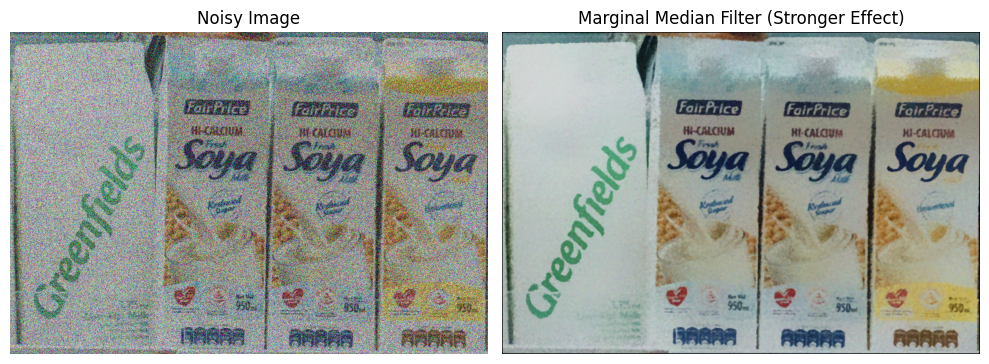

In [62]:

# Load the image
image_path = "./dataset/scenes/scene8.png"
image = cv2.imread(image_path)

# Apply the marginal median filter with a larger filter size and multiple iterations
filter_size = 5  # Increase the filter size for a stronger effect
iterations = 2  # Apply the filter multiple times for a stronger effect
filtered_image_marginal = medianFilterMarginal_kri(image, filter_size, iterations)
bilateral_median = cv2.bilateralFilter(filtered_image_marginal, 150, 60, 50)

# Convert to RGB for plotting
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
filtered_image_marginal_rgb = cv2.cvtColor(bilateral_median, cv2.COLOR_BGR2RGB)

# Plot the original and filtered images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Noisy Image")
plt.imshow(image_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Marginal Median Filter (Stronger Effect)")
plt.imshow(filtered_image_marginal_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()

In [56]:
def medianFilterMarginal(img, filterSize=3, iterations=1):
    imgHeight, imgWidth, channels = img.shape
    outputImg = img.copy()

    filterHeight = filterWidth = filterSize
    filterEdge = filterWidth // 2

    for _ in range(iterations):
        newOutputImg = np.zeros((imgHeight, imgWidth, channels), dtype=np.uint8)
        for i in range(filterEdge, imgHeight - filterEdge):
            for j in range(filterEdge, imgWidth - filterEdge):
                # Get a frame around the pixel by the filter size
                imgFilter = outputImg[i - filterEdge : i + filterEdge + 1, j - filterEdge : j + filterEdge + 1]

                # Separate channels, reshape to a one-dimensional array and sort it
                red = np.sort(imgFilter[:, :, 0].reshape(filterHeight * filterWidth))
                green = np.sort(imgFilter[:, :, 1].reshape(filterHeight * filterWidth))
                blue = np.sort(imgFilter[:, :, 2].reshape(filterHeight * filterWidth))

                # Get the median intensity
                newOutputImg[i][j][0] = red[(filterWidth * filterHeight) // 2]
                newOutputImg[i][j][1] = green[(filterWidth * filterHeight) // 2]
                newOutputImg[i][j][2] = blue[(filterWidth * filterHeight) // 2]
        
        outputImg = newOutputImg

    return outputImg


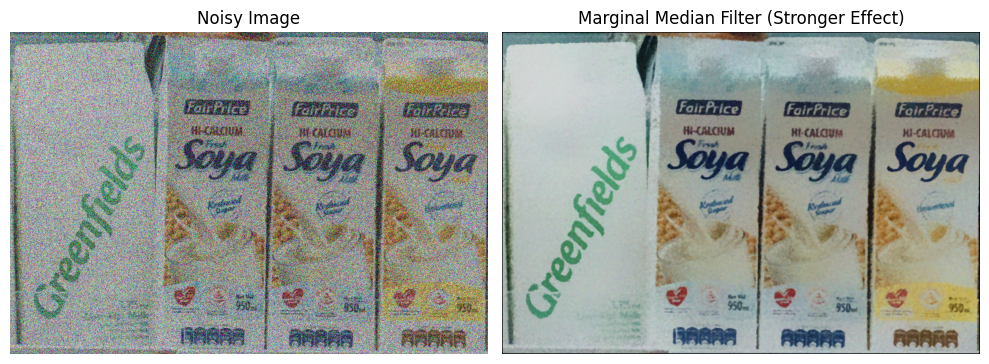

In [58]:
# Load the image
image_path = "./dataset/scenes/scene8.png"
image = cv2.imread(image_path)

# Apply the marginal median filter with a larger filter size and multiple iterations
filter_size = 5  # Increase the filter size for a stronger effect
iterations = 2  # Apply the filter multiple times for a stronger effect
filtered_image_marginal = medianFilterMarginal(image, filter_size, iterations)
bilateral_median = cv2.bilateralFilter(filtered_image_marginal, 150, 60, 50)

# Convert to RGB for plotting
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
filtered_image_marginal_rgb = cv2.cvtColor(bilateral_median, cv2.COLOR_BGR2RGB)

# Plot the original and filtered images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Noisy Image")
plt.imshow(image_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Marginal Median Filter (Stronger Effect)")
plt.imshow(filtered_image_marginal_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
scene1_dn = show_denoising('./dataset/scenes/scene4.png', 9, 3, True)


In [63]:
def extract_number(string):
    # Using regex to find numbers in the string
    numbers = re.findall(r'\d+', string)
    # Returning the first number found (if any)
    return int(numbers[0]) if numbers else None

In [6]:
def denoise_scenes(img_path, kind):
    '''
    Takes a single image path as an input and executes the denoising according to the desired method.
    Once that's done it saves the results in the denoised_scenes folder.
    '''
    #####BEFORE RUNNING THIS CREATE A 'denoised_scenes' folder inside 'dataset'
    img= cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_index= extract_number(img_path)

    median = cv2.medianBlur(img, 5)
    if kind=='dst':
        img = cv2.fastNlMeansDenoisingColored(median,None,10,10,7,21)
    elif kind=='bilateral':
        img = cv2.bilateralFilter(median, 5, 150, 75)
    elif kind == 'tutti':
        means_and_median = cv2.fastNlMeansDenoisingColored(median,None,10,10,7,21)
        img = cv2.bilateralFilter(means_and_median, 5, 150, 75)

    img_write = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    cv2.imwrite(f'./dataset/denoised_scenes/scene{img_index}.png', img_write)



### Creating auxiliary arrays to browse the images

In [37]:
scenes_path = './dataset/scenes/scene'

scene_idx_start_a = 1
scene_idx_end_a = 5
scene_idx_start_b = 6
scene_idx_end_b = 12

scenes_a = [f"{scenes_path}{i}.png" for i in range(scene_idx_start_a, scene_idx_end_a + 1)]
scenes_b = [f"{scenes_path}{i}.png" for i in range(scene_idx_start_b, scene_idx_end_b + 1)]

In [38]:
dn_scenes_path = './dataset/denoised_scenes/scene'

dn_scenes_a = [f"{dn_scenes_path}{i}.png" for i in range(scene_idx_start_a, scene_idx_end_a + 1)]
dn_scenes_b = [f"{dn_scenes_path}{i}.png" for i in range(scene_idx_start_b, scene_idx_end_b + 1)]

In [39]:
models_path = './dataset/models/ref'

start_index_a = 1
end_index_a = 14
start_index_b = 15
end_index_b = 27

# Generate the array of file paths
objs_a = [f"{models_path}{i}.png" for i in range(start_index_a, end_index_a + 1)]
objs_b = [f"{models_path}{i}.png" for i in range(start_index_b, end_index_b + 1)]

### Denoise Scenes

In [ ]:
for scene in scenes_a:
    denoise_scenes(scene, 'tutti')
for scene in scenes_b:
    denoise_scenes(scene, 'tutti')

In [66]:
filter_size = 5  # Increase the filter size for a stronger effect
iterations = 2
for scene in scenes_b:
    medianFilterMarginal_kri(scene, filter_size, iterations)

## Track A

### Auxiliary function to manage each step of the recognition more easily

In [45]:
def show_output(prod_instances):
    '''
    Function which take every instance of a match between products and scene and 
    prints them in the required format
    '''
    
    for product in prod_instances:
        c = 1
        print(f"Product: {product['name']} - {product['count']} instance found")
        for instance in product['instances']:
            print(f'\t Instance {c} - position: {instance[2]}, width: {instance[1]} px, height:{instance[0]}px, scene:{instance[3]}')
            c = c+1

In [ ]:
def show_box(img_path, dst):
    ''''
    Show the bounding box found after the recognition
    '''
    
    img_ob = cv2.imread(img_path)
    img = cv2.cvtColor(img_ob, cv2.COLOR_BGR2RGB)
    img_train_p = cv2.polylines(img,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    plt.imshow(img_train_p, 'gray')
    plt.show()

In [ ]:
def siftDetect(img_path):
    '''
    Initialization of Sift algorithm, instatiation of images as cv2 objs
    and calculation of kp and descriptors
    '''
    sift = cv2.SIFT_create()

    img_ob = cv2.imread(img_path)
    img = cv2.cvtColor(img_ob, cv2.COLOR_BGR2RGB)

    #this is the computing of the keypoints and descriptors
    keypoints, descriptors = sift.detectAndCompute(img, None)

    return keypoints, descriptors

In [40]:
def flannMatch(img_ref_path, img_scene_path):
    '''
    Initialization of the FLANN matcher, to match kp from the 2 images
    '''

    FLANN_INDEX_KDTREE = 1

    # Defining parameters for algorithm
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

    # Defining search params.
    # checks=50 specifies the number of times the trees in the index should be recursively traversed.
    # Higher values gives better precision, but also takes more time
    search_params = dict(checks = 50)

    # Initializing matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    kp_ref, des_ref = siftDetect(img_ref_path)
    kp_scene, des_scene = siftDetect(img_scene_path)

    # Matching and finding the 2 closest elements for each query descriptor.
    matches = flann.knnMatch(des_ref,des_scene,k=2)
    
    return matches


In [41]:
def loweFilter(matches):
    '''
    Filter to distinguish valuable matches trough a treshold
    '''
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    return good

In [43]:
def homography(good, img_ref_path, img_scene_path, treshold):

    #TODO switch to a dynamic tresholding mechanism

    img_ob = cv2.imread(img_ref_path)
    img_ref = cv2.cvtColor(img_ob, cv2.COLOR_RGB2BGR)
    
    if len(good) > treshold:
        print(f'{img_ref_path} present in {img_scene_path}')
        kp_ref, des_ref = siftDetect(img_ref_path)
        kp_scene, des_scene = siftDetect(img_scene_path)
        # building the correspondences arrays of good matches
        src_pts = np.float32([kp_ref[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_scene[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
        # Using RANSAC to estimate a robust homography.
        # It returns the homography M and a mask for the discarded points
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # Mask of discarded point used in visualization
        matchesMask = mask.ravel().tolist()

        # Corners of the query image
        h, w, c = img_ref.shape
        pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)

        # Projecting the corners into the train image
        dst = cv2.perspectiveTransform(pts, M)
        
        ret_array=[h,w, dst[0][0]]       
        return ret_array
    else:
        #TODO: see if there is an alternative to this return
        return []

### Single Instance Matching Function

In [44]:
def check_matching(img_ref_path, img_scene_path, treshold):
    '''
    Function which matches the obj image with the required scene. 
    It returns an array which is functional to format the output in the required style.
    '''

    #Finding kp, desc and all the matches
    matches = flannMatch(img_ref_path, img_scene_path)
    #filtering the matches trough a treshold
    good = loweFilter(matches)
    #TODO: we always pass the img path instead of cv2 obj, a bit inefficient
    ret_array = homography(good, img_ref_path, img_scene_path, treshold)
    
    return ret_array

In [16]:
# def check_matching_old(img_obj_path, img_scene_path, treshold):
    
#     img_ob = cv2.imread(img_obj_path)
#     img_obj = cv2.cvtColor(img_ob, cv2.COLOR_BGR2RGB)

#     scene_ob = cv2.imread(img_scene_path)
#     img_scene = cv2.cvtColor(scene_ob, cv2.COLOR_BGR2RGB)

#     sift =cv2.SIFT_create()
#     kp_query = sift.detect(img_obj)
#     kp_train =sift.detect(img_scene)
#     kp_query, des_query = sift.compute(img_obj, kp_query)
#     kp_train, des_train = sift.compute(img_scene, kp_train)

#     #treshold_percentage = len(kp_query) * treshold

#     FLANN_INDEX_KDTREE = 1
#     index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
#     search_params = dict(checks=50)

#     flann = cv2.FlannBasedMatcher(index_params, search_params)
#     matches = flann.knnMatch(des_query, des_train, k=2)

#     good = []
#     for m, n in matches:
#         if m.distance < 0.6 * n.distance:
#             good.append(m)

#     if len(good) > treshold:
#         print(f'{img_obj_path} present in {img_scene_path}')
        
#         # building the correspondences arrays of good matches
#         src_pts = np.float32([kp_query[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
#         dst_pts = np.float32([kp_train[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
#         # Using RANSAC to estimate a robust homography.
#         # It returns the homography M and a mask for the discarded points
#         M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

#         # Mask of discarded point used in visualization
#         matchesMask = mask.ravel().tolist()

#         # Corners of the query image
#         h, w,c = img_obj.shape
#         pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)

#         # Projecting the corners into the train image
#         dst = cv2.perspectiveTransform(pts, M)
         
#         ret_array=[h,w, dst[0][0]]       
#         return ret_array
#     else:
#         #print(f'Not enough matches are found - {len(good)}/{treshold_percentage}')
#         return []


#### Execution examples

In [19]:
prod_instances=[]
for obj in objs_a:
    prod_description={}
    obj_instances=[]
    prod_description['name'] = extract_number(obj)
    for scene in dn_scenes_a:
        ret_array= check_matching(obj, scene, 80)
        
        
        #heigth, width, pos = check_matching(obj, scene, 0.027)
        if(len(ret_array)>0):
            ret_array.append(extract_number(scene))
            obj_instances.append(ret_array)
            #print(ret_array)
    prod_description['instances']=obj_instances    
    prod_description['count'] = len(obj_instances)
    prod_instances.append(prod_description)
    
print('###########################')


./dataset/models/ref1.png present in ./dataset/denoised_scenes/scene1.png
./dataset/models/ref1.png present in ./dataset/denoised_scenes/scene4.png
./dataset/models/ref2.png present in ./dataset/denoised_scenes/scene1.png
./dataset/models/ref3.png present in ./dataset/denoised_scenes/scene2.png
./dataset/models/ref4.png present in ./dataset/denoised_scenes/scene2.png
./dataset/models/ref5.png present in ./dataset/denoised_scenes/scene2.png
./dataset/models/ref8.png present in ./dataset/denoised_scenes/scene3.png
./dataset/models/ref11.png present in ./dataset/denoised_scenes/scene5.png
###########################


In [46]:
#Testing the matches for the first five scenes
for scene in dn_scenes_a:
    for obj in objs_a:
        ret_array= check_matching(obj, scene, treshold=60)
    print('\n')

./dataset/models/ref1.png present in ./dataset/denoised_scenes/scene1.png
./dataset/models/ref2.png present in ./dataset/denoised_scenes/scene1.png
./dataset/models/ref5.png present in ./dataset/denoised_scenes/scene1.png
./dataset/models/ref14.png present in ./dataset/denoised_scenes/scene1.png


./dataset/models/ref2.png present in ./dataset/denoised_scenes/scene2.png
./dataset/models/ref3.png present in ./dataset/denoised_scenes/scene2.png
./dataset/models/ref4.png present in ./dataset/denoised_scenes/scene2.png
./dataset/models/ref5.png present in ./dataset/denoised_scenes/scene2.png
./dataset/models/ref8.png present in ./dataset/denoised_scenes/scene2.png
./dataset/models/ref14.png present in ./dataset/denoised_scenes/scene2.png


./dataset/models/ref3.png present in ./dataset/denoised_scenes/scene3.png
./dataset/models/ref6.png present in ./dataset/denoised_scenes/scene3.png
./dataset/models/ref7.png present in ./dataset/denoised_scenes/scene3.png
./dataset/models/ref8.png presen

In [ ]:
show_output(prod_instances)

# Track B

In [47]:
def fillArea(img, dst):
    # Ensure dst is a NumPy array
    dst = np.array(dst, dtype=np.int32)
    
    # Reshape if needed (assuming dst is a flat list of points)
    if dst.ndim == 1:
        dst = dst.reshape((-1, 2))
    
    # Ensure dst has the shape (1, n, 2) for fillPoly
    dst = dst.reshape((1, -1, 2))
    
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, dst, (255,))
    img = cv2.add(img, mask)
    return img

In [48]:
for scene in dn_scenes_b:
    for obj in objs_b:
        ret_array= check_matching(img_ref_path=obj, img_scene_path=scene, treshold=40)
    print('\n')

./dataset/models/ref15.png present in ./dataset/denoised_scenes/scene6.png


./dataset/models/ref16.png present in ./dataset/denoised_scenes/scene7.png


./dataset/models/ref17.png present in ./dataset/denoised_scenes/scene8.png
./dataset/models/ref23.png present in ./dataset/denoised_scenes/scene8.png
./dataset/models/ref24.png present in ./dataset/denoised_scenes/scene8.png
./dataset/models/ref26.png present in ./dataset/denoised_scenes/scene8.png


./dataset/models/ref19.png present in ./dataset/denoised_scenes/scene9.png
./dataset/models/ref20.png present in ./dataset/denoised_scenes/scene9.png




./dataset/models/ref17.png present in ./dataset/denoised_scenes/scene11.png
./dataset/models/ref23.png present in ./dataset/denoised_scenes/scene11.png


./dataset/models/ref26.png present in ./dataset/denoised_scenes/scene12.png




In [ ]:
# i = scene_idx_start_b
# for scene in dn_scenes_b:
#     #transform the path into a scene
#     scene_ob = cv2.imread(scene)
#     img_scene = cv2.cvtColor(scene_ob, cv2.COLOR_BGR2RGB)

#     #now parameters we need
#     dst_list = []
#     object_info_list = []

#     kp_scene, dsp_scene = siftDetect(scene)
#     img_scene_c = img_scene.copy()
#     img_scene_c_path = f'dataset/copied_images/scene{i}.png'
#     img_write = cv2.cvtColor(img_scene_c, cv2.COLOR_RGB2BGR )
#     cv2.imwrite(img_scene_c_path, img_write)
    

#     for ref in objs_b:
#         img_ob = cv2.imread(ref)
#         img_ref = cv2.cvtColor(img_ob, cv2.COLOR_RGB2BGR)
#         while True:
#             ret_array = check_matching(ref, scene)
#             dst = ret_array[2]
#             if dst is None:
#                 break

#             print(dst)
#             dst_list.extend(np.int32(dst).flatten())
#             print(dst_list)  # Output: [418, 165]
#             img_scene_c = fillArea(img_scene_c, dst)
#             img_scene_c = cv2.cvtColor(img_scene_c, cv2.COLOR_RGB2BGR)
#             kp_scene, dsp_scene = siftDetect(img_scene_c_path)

#     show_box(scene, dst_list)
#     i = i+1

    

In [ ]:
# for scene in dn_scenes_b:
#     print(scene)
#     for ref in objs_b:
#         print(ref)
#         img_rgb = cv2.imread(scene)
#         assert img_rgb is not None, "file could not be read, check with os.path.exists()"
#         img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
#         template = cv2.imread(ref)
#         print(img_gray, )
#         assert template is not None, "file could not be read, check with os.path.exists()"
#         w, h, c = template.shape
        
#         res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)
#         if len(res)>0:
#             threshold = 0.7
#             loc = np.where( res >= threshold)
#             for pt in zip(*loc[::-1]):
#                 cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
#         else:
#             print("[]")

#         idx = extract_number(scene) 
#         img_write = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
#         cv2.imwrite(f'dataset/copied_images/scene{idx}.png',img_rgb)

In [67]:

# Iterate over each scene
for scene_path in dn_scenes_b:
    img_rgb = cv2.imread(scene_path)
    assert img_rgb is not None, f"Scene file {scene_path} could not be read, check with os.path.exists()"

    # Iterate over each template
    for template_path in objs_b:
        template_rgb = cv2.imread(template_path)
        assert template_rgb is not None, f"Template file {template_path} could not be read, check with os.path.exists()"

        # Ensure the template and image have the same number of channels
        if template_rgb.shape[2] != img_rgb.shape[2]:
            raise ValueError("The template and image must have the same number of channels")

        # Check if template is larger than the image
        if template_rgb.shape[0] > img_rgb.shape[0] or template_rgb.shape[1] > img_rgb.shape[1]:
            print(f"Skipping template {template_path} because it is larger than the scene {scene_path}")
            continue

        # Perform template matching
        res = cv2.matchTemplate(img_rgb, template_rgb, cv2.TM_CCOEFF_NORMED)

        # Define the threshold and find locations where matching results are above the threshold
        threshold = 0.8
        loc = np.where(res >= threshold)

        # Draw rectangles around matched regions
        for pt in zip(*loc[::-1]):
            cv2.rectangle(img_rgb, pt, (pt[0] + template_rgb.shape[1], pt[1] + template_rgb.shape[0]), (0, 0, 255), 2)

    # Save the result for the current scene
    result_path = f'./dataset/copied_images/res_{os.path.basename(scene_path)}'
    cv2.imwrite(result_path, img_rgb)
    print(f"Results saved for {scene_path} as {result_path}")


Skipping template ./dataset/models/ref16.png because it is larger than the scene ./dataset/denoised_scenes/scene6.png
Skipping template ./dataset/models/ref18.png because it is larger than the scene ./dataset/denoised_scenes/scene6.png
Skipping template ./dataset/models/ref19.png because it is larger than the scene ./dataset/denoised_scenes/scene6.png
Skipping template ./dataset/models/ref20.png because it is larger than the scene ./dataset/denoised_scenes/scene6.png
Skipping template ./dataset/models/ref21.png because it is larger than the scene ./dataset/denoised_scenes/scene6.png
Skipping template ./dataset/models/ref22.png because it is larger than the scene ./dataset/denoised_scenes/scene6.png
Results saved for ./dataset/denoised_scenes/scene6.png as ./dataset/copied_images/res_scene6.png
Skipping template ./dataset/models/ref15.png because it is larger than the scene ./dataset/denoised_scenes/scene7.png
Skipping template ./dataset/models/ref16.png because it is larger than the sc